In [1]:
import torch
import numpy as np
import torch.nn as nn
import networks
import replaybuffer
import gym
import matplotlib.pyplot as plt
import sys, os
import utils
# import open3d as o3d
import time
# import PointCloudsGenerator as PCG
import GPUtil
from torch.utils.tensorboard import SummaryWriter

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash /home/as/xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
import dm_control
import numpy as np
import math

from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=DeprecationWarning, message='Using or importing the ABCs')


/home/albert/anaconda3/envs/drqv2/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [3]:
from torchvision.transforms import Resize
from PIL import Image
import numpy as np
from gym.spaces import Box


class Wrapper:
    """ Partially solves problem with  compatibality"""

    def __init__(self, env):
        self._env = env
        self.observation_space, self.action_space = self._infer_spaces(env)

    def observation(self, timestamp):
        return timestamp.observation

    def reward(self, timestamp):
        return np.float32(timestamp.reward)

    def done(self, timestamp):
        return timestamp.last()

    def step(self, action):
        timestamp = self._env.step(action)
        obs = self.observation(timestamp)
        r = self.reward(timestamp)
        d = self.done(timestamp)
        return obs, r, d, None

    def reset(self):
        return self.observation(self._env.reset())

    @staticmethod
    def _infer_spaces(env):
        lim = 1.
        spec = env.action_spec()
        action_space = Box(low=spec.minimum.astype(np.float32), dtype=np.float32,
                           high=spec.maximum.astype(np.float32), shape=spec.shape)
        ar = list(env.observation_spec().values())[0]
        obs_sample = np.concatenate(list(map(lambda ar: ar.generate_value() if ar.shape != () else [1],
                                             env.observation_spec().values())))
        obs_space = Box(low=-lim, high=lim, shape=obs_sample.shape, dtype=ar.dtype)
        return obs_space, action_space

    @property
    def unwrapped(self):
        if hasattr(self._env, 'unwrapped'):
            return self._env.unwrapped
        return self._env

    def __getattr__(self, item):
        return getattr(self._env, item)

    def __repr__(self):
        return f"{self.__class__.__name__}"

In [4]:
class dmWrapper(Wrapper):
    def __init__(self, env):
        self._env = env

    # def observation(self, timestamp):
    #     obs = np.array([])
    #     for v in timestamp.observation.values():
    #         if not v.ndim:
    #             v = v[None]
    #         obs = np.concatenate((obs, v))
    #     return obs.astype(np.float32)

    def observation(self, timestamp):
        obs = np.array([])
        for v in timestamp.observation.values():
            if not v.ndim:
                v = v[None]
            obs = np.concatenate((obs, v.flatten()))
        return obs.astype(np.float32)
    
    def reset(self):
        return self.observation(self._env.reset())

    def render(self, camera_id=0):
        return self._env.physics.render(camera_id=camera_id)    

    def step(self, action):
        timestamp = self._env.step(action)
        obs = self.observation(timestamp)
        r = timestamp.reward
        d = timestamp.last()
        return obs, r, d, None

In [5]:
suite.ALL_TASKS

(('acrobot', 'swingup'),
 ('acrobot', 'swingup_sparse'),
 ('ball_in_cup', 'catch'),
 ('cartpole', 'balance'),
 ('cartpole', 'balance_sparse'),
 ('cartpole', 'swingup'),
 ('cartpole', 'swingup_sparse'),
 ('cartpole', 'two_poles'),
 ('cartpole', 'three_poles'),
 ('cheetah', 'run'),
 ('dog', 'stand'),
 ('dog', 'walk'),
 ('dog', 'trot'),
 ('dog', 'run'),
 ('dog', 'fetch'),
 ('finger', 'spin'),
 ('finger', 'turn_easy'),
 ('finger', 'turn_hard'),
 ('fish', 'upright'),
 ('fish', 'swim'),
 ('hopper', 'stand'),
 ('hopper', 'hop'),
 ('humanoid', 'stand'),
 ('humanoid', 'walk'),
 ('humanoid', 'run'),
 ('humanoid', 'run_pure_state'),
 ('humanoid_CMU', 'stand'),
 ('humanoid_CMU', 'run'),
 ('lqr', 'lqr_2_1'),
 ('lqr', 'lqr_6_2'),
 ('manipulator', 'bring_ball'),
 ('manipulator', 'bring_peg'),
 ('manipulator', 'insert_ball'),
 ('manipulator', 'insert_peg'),
 ('pendulum', 'swingup'),
 ('point_mass', 'easy'),
 ('point_mass', 'hard'),
 ('quadruped', 'walk'),
 ('quadruped', 'run'),
 ('quadruped', 'escape'

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# env = manipulation.load('reach_site_features', seed=42)
# random_state = np.random.RandomState(42)
# test_env = manipulation.load('reach_site_features', seed=42)

ENV_NAME = 'cartpole'
ENV_TASK = 'swingup'

env = suite.load(ENV_NAME, ENV_TASK)
test_env = suite.load(ENV_NAME, ENV_TASK)

env = dmWrapper(env)
test_env = dmWrapper(test_env)

s = env.reset()
s = test_env.reset()




cuda:0


In [7]:
s.shape

(5,)

In [8]:
env.action_spec()

/home/albert/anaconda3/envs/drqv2/lib/python3.8/site-packages/dm_control/mujoco/engine.py:1026: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  minima = np.full(num_actions, fill_value=-constants.mjMAXVAL, dtype=np.float)
/home/albert/anaconda3/envs/drqv2/lib/python3.8/site-packages/dm_control/mujoco/engine.py:1027: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-note

BoundedArray(shape=(1,), dtype=dtype('float64'), name=None, minimum=[-1.], maximum=[1.])

In [9]:
hyper = {
    'state_dim': 5,
    # 'state_dim': (3, 1000, 3),
    # 'state_dim': (3, 1000),
    'act_dim': 1,
    'device': device.type + ':' + str(device.index),
    # 'enc_type': 'PointCloud',
    'enc_type': 'Linear',
    'hid_size': 64,
    'num_filters': 32,
    'alpha': 0.01,
    'polyak': 0.995,
    'lr': 3e-4,
    'batch_size': 256,
    'gamma': 0.99,
    'n_eval_games': 10,
    'max_episod_len': 1000,
    'eval_freq': 10000,
    'total_steps': 5000000,
    'buffer_size': 100000,
    'start_steps': 10000,
    # 'start_steps': 1,
    'update_freq': 1,
    'aug_flag': False,
    'aug_pad': 4,
}

LOG_DIR = './logs/pic/' + ENV_NAME + '_' + ENV_TASK

logger = SummaryWriter(LOG_DIR)
logger.add_hparams(hyper, 
                {'loss': 0})


print(hyper['state_dim'])
print(hyper['act_dim'])

/home/albert/anaconda3/envs/drqv2/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/albert/anaconda3/envs/drqv2/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:555: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/albert/anaconda3/envs/drqv2/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a depreca

5
1


In [10]:
agent = networks.SACAgent(hyper['state_dim'], hyper['act_dim'], hyper['device'], hyper['enc_type'], hyper['hid_size'], hyper['num_filters'], hyper['alpha'], hyper['polyak'], hyper['lr'], hyper['batch_size'], hyper['gamma'])

print(agent)

SACAgent(
  (policy): Actor(
    (enc): MLPEncoder(
      (net): Sequential(
        (0): Linear(in_features=5, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
      )
    )
    (mu): Linear(in_features=64, out_features=1, bias=True)
    (log_std): Linear(in_features=64, out_features=1, bias=True)
  )
  (Q1): Critic(
    (enc): MLPEncoder(
      (net): Sequential(
        (0): Linear(in_features=6, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
      )
    )
    (q): Linear(in_features=64, out_features=1, bias=True)
  )
  (Q2): Critic(
    (enc): MLPEncoder(
      (net): Sequential(
        (0): Linear(in_features=6, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
      )
    )
    (q): Linear(in_features=64, out_features=1, bias=True)
 

In [11]:
print(sum(p.numel() for p in agent.parameters()))

28040


In [12]:
def evaluate(env, agent, n_games=1, max_episod_len=hyper['max_episod_len']):
    reward = 0
    act = []
    for n in range(n_games):
        s = env.reset()
        # s = torch.Tensor([s], dtype=torch.float32, device=hyper['device'])
        for st in range(max_episod_len):
            a = agent.get_action([s], determ=True).cpu().numpy()[0]
            s, r, d, _ = env.step(a)
            reward += r
            act.append(a)
            if d:
                # act.append(0)
                break
    return (reward/n_games), act

In [13]:
step = 0
steps = []
buffer = replaybuffer.ReplayBufer(hyper['buffer_size'], hyper['act_dim'], hyper['state_dim'], hyper['device'], image_pad=hyper['aug_pad'], enc_type=hyper['enc_type'], aug_flag=hyper['aug_flag'])
# buffer = replaybuffer.TensorReplayBufer(hyper['buffer_size'], hyper['act_dim'], hyper['state_dim'], 'cpu', image_pad=hyper['aug_pad'], enc_type=hyper['enc_type'], aug_flag=hyper['aug_flag'])
state = env.reset()
return_hist = []
q1_hist = []
q2_hist = []
acts = []
entropy_hist = []
alpha_hist = []
q1_grad_hist = []
q2_grad_hist = []

policy_grad_hist = []


max_mean_return = -100000

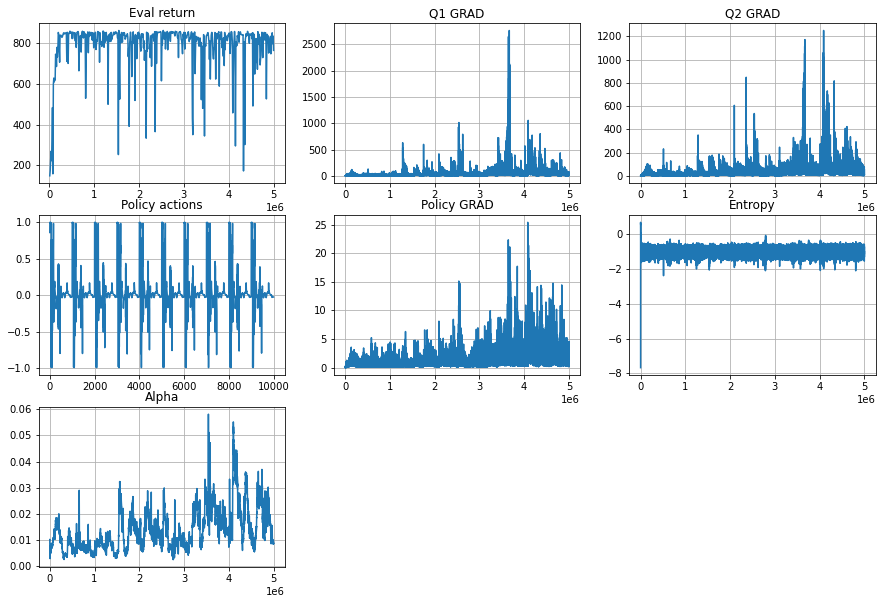

100%|██████████| 5000001/5000001 [14:32:46<00:00, 95.48it/s] 


In [14]:
import tqdm
from IPython.display import clear_output
import time

ep_len = 0


with tqdm.trange(step, hyper['total_steps'] + 1) as progress_bar:
    for step in progress_bar:
        if step > hyper['start_steps']:
            # ss = time.time()
            action = agent.get_action([state]).cpu().numpy()[0]
            # ee = time.time()
            # print("get action", ee - ss)
        else:
            # action = env.action_space.sample()
            action = np.random.uniform(-1, 1, size=(1,))
        
        # if ep_len == 0:
        #     with torch.no_grad():
        #         q1_hist.append(agent.Q1(torch.as_tensor([state], dtype=torch.float32, device=agent.device), torch.as_tensor([action], dtype=torch.float32, device=agent.device)).item())
        #         q2_hist.append(agent.Q2(torch.as_tensor([state], dtype=torch.float32, device=agent.device), torch.as_tensor([action], dtype=torch.float32, device=agent.device)).item())


        next_state, reward, done, _ = env.step(action)
        
        ep_len += 1



        done = False if (ep_len == hyper['max_episod_len']) else done
        buffer.store(state, action, reward, next_state, done)
        state = next_state

        if done or (ep_len == hyper['max_episod_len']):
            state = env.reset()
            ep_len = 0
        
        
        if step % hyper['update_freq'] == 0:

            # ss = time.time()
            s, a, r, s_next, d = buffer.sample_batch(hyper['batch_size'])
            # ee = time.time()
            # print("Sample Batch", ee - ss)

            # ss = time.time()
            agent.update(s, a, r, s_next, d)
            # ee = time.time()
            # print("update", ee - ss)
            q1_grad_hist.append(agent.q1_grad.item())
            q2_grad_hist.append(agent.q2_grad.item())
            policy_grad_hist.append(agent.policy_grad.item())
            entropy_hist.append(agent.entropy.item())
            alpha_hist.append(agent.log_alpha.exp().cpu().item())

            logger.add_scalar('grads/Q1_grad', agent.q1_grad.item(), step)
            logger.add_scalar('grads/Q2_grad', agent.q2_grad.item(), step)
            logger.add_scalar('grads/Policy_grad', agent.policy_grad.item(), step)
            logger.add_scalar('entropy/Entropy', agent.entropy.item(), step)
            logger.add_scalar('entropy/Alpha', agent.log_alpha.exp().cpu().item(), step)
            logger.add_scalar('return/Buffer_mean_reward', buffer.rew_buf.mean(), step)

        if (step+1) % hyper['eval_freq'] == 0:
            mean_return, pol = evaluate(test_env, agent, hyper['n_eval_games'])
            
            logger.add_scalar('return/Eval_return', mean_return, step)

            clear_output()
            steps.append(step)
            return_hist.append(mean_return)
            
            if mean_return > max_mean_return:
                torch.save(agent, 'best_agent_.pth')
                max_mean_return = mean_return

            figg = plt.figure(figsize=(15, 10))

            plt.subplot(3, 3, 1)
            plt.title('Eval return')
            plt.plot(steps, return_hist)
            plt.grid(True)

            plt.subplot(3, 3, 2)
            plt.title('Q1 GRAD')
            plt.plot(q1_grad_hist)
            plt.grid(True)

            plt.subplot(3, 3, 3)
            plt.title('Q2 GRAD')
            plt.plot(q2_grad_hist)
            plt.grid(True)
            
            plt.subplot(3, 3, 4)
            plt.title('Policy actions')
            plt.plot(pol)
            plt.grid(True)

            plt.subplot(3, 3, 5)
            plt.title('Policy GRAD')
            plt.plot(policy_grad_hist)
            plt.grid(True)

            plt.subplot(3, 3, 6)
            plt.title('Entropy')
            plt.plot(entropy_hist)
            plt.grid(True)

            plt.subplot(3, 3, 7)
            plt.title('Alpha')
            plt.plot(alpha_hist)
            plt.grid(True)

            plt.show()
            
            # figg.savefig('gr1.png')

            torch.save(agent, 'last_agent1.pth')

In [35]:
agent = torch.load('best_agent_reacher_easy_state.pth')

In [36]:
import utils

In [37]:
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def record_video(env, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  rec = utils.VideoRecorder(video_folder, 320, 240, fps=10)
  rec.init()
  obs = env.reset()
  for _ in range(video_length):
    rec.record(env)
    action = agent.get_action([obs], determ=True).cpu().numpy()[0]
    obs, _, d, _ = env.step(action)
    # print(d)
    if d:
      print(d)
      obs = env.reset()
  rec.save('cartpole_swingup.mp4')

sh: 1: Xvfb: not found


In [38]:
record_video(test_env, agent)